# 1. Exploratory Data Analysis

In [24]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [25]:
generation_data = pd.read_csv("../data/raw/energy_dataset.csv", parse_dates=["time"])
generation_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [26]:
weather_data = pd.read_csv("../data/raw/weather_features.csv", parse_dates=["dt_iso"])
weather_data.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


# Electricity Price Time Series Analysis

In [27]:
## Select price actual 
price_df = generation_data.set_index("time") \
               .filter(["price actual"]) \
               .asfreq("H") \
               .sort_index()

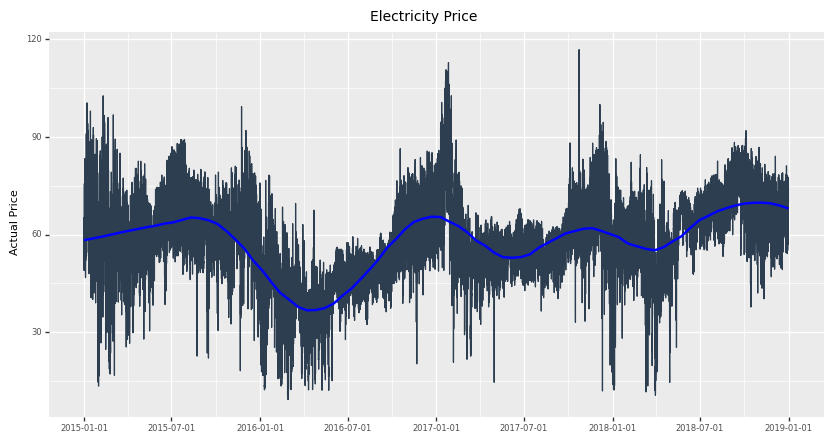

<ggplot: (8748334575151)>

In [28]:
ggplot(data=price_df.reset_index(), mapping=aes(x="time", y="price actual")) + \
geom_line(color = "#2C3E50") + \
    geom_smooth(method = "loess",
                se = False,
                color = "blue",
                span = 0.3) + \
    labs(
        title = "Electricity Price",
        x = "",
        y = "Actual Price"
    ) + \
    theme(axis_text_y = element_text(size = 6),
          axis_text_x = element_text(size = 6),
          plot_title  = element_text(size = 10),
          axis_title_y= element_text(size=8),
          figure_size=(10,5)
          )

<Axes: ylabel='Frequency'>

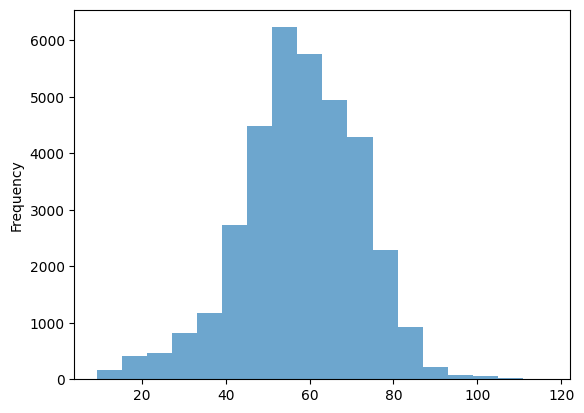

In [29]:
price_df["price actual"].plot.hist(bins = 18, alpha = 0.65)

In [30]:
# Check time series structure
price_df.index.is_unique

True

In [31]:
price_df.isna().sum()

price actual    0
dtype: int64

## Time series decomposition 

In [32]:
res = STL(price_df["price actual"], robust = True).fit()
seasonal, trend, resid = res.seasonal, res.trend, res.resid

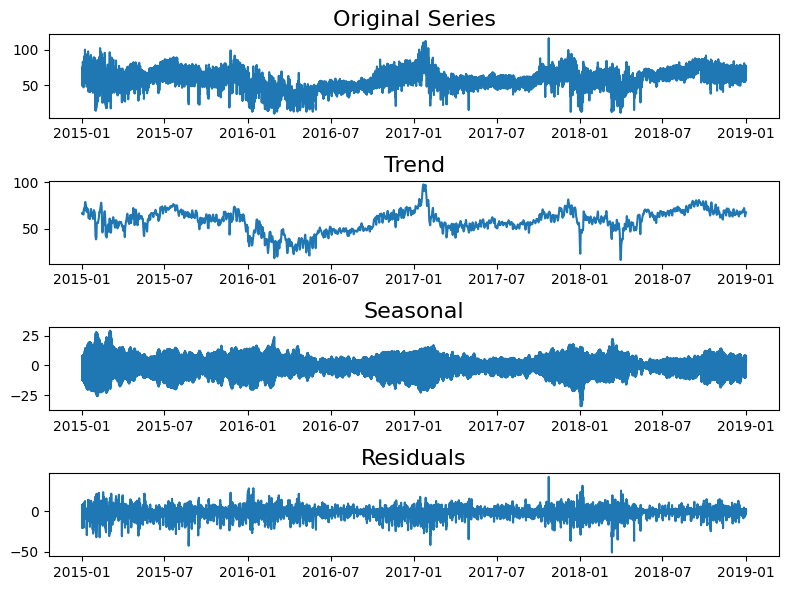

In [33]:
plt.figure(figsize=(8,6))

plt.subplot(4, 1, 1)
plt.plot(price_df["price actual"])
plt.title('Original Series', fontsize = 16)

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend', fontsize = 16)

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize = 16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residuals', fontsize = 16)

plt.tight_layout()

## Trend and Seasonality Analysis

In [34]:
# Trend analysis: extract trend with LOESS
y = price_df["price actual"]
x = np.arange(0, len(y))

res = lowess(endog = y, exog = x, frac = 0.1, it = 3)
price_df['lowess'] = res[:, 1]
price_df.head()

,price actual,lowess
time,,
2015-01-01 00:00:00+01:00,65.41,65.892154
2015-01-01 01:00:00+01:00,64.92,65.886955
2015-01-01 02:00:00+01:00,64.48,65.881756
2015-01-01 03:00:00+01:00,59.32,65.876559
2015-01-01 04:00:00+01:00,56.04,65.871362


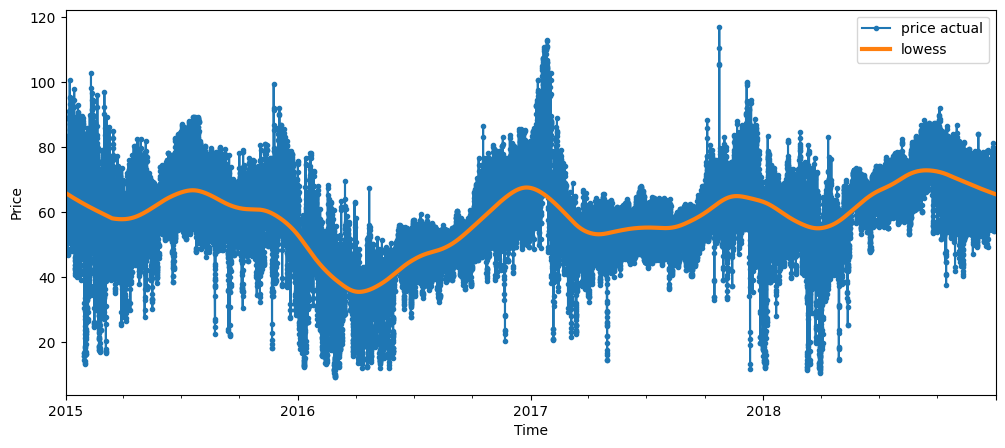

In [35]:
fig, ax = plt.subplots(figsize = [12,5])
price_df.plot(y = 'price actual', marker = '.', ax = ax)
price_df.plot(y = 'lowess', ax = ax, linewidth = 3)
ax.set_ylabel('Price')
ax.set_xlabel('Time')
plt.show()

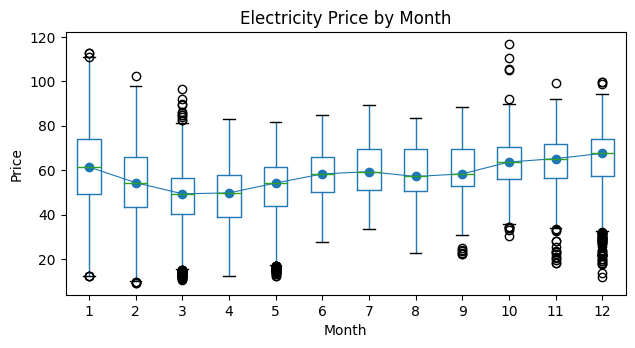

In [36]:
# Seasonality analysis
## 1. Annual seasonality

fig, ax = plt.subplots(figsize = [7, 3.5])
price_df['month'] = price_df.index.month
price_df.boxplot(column='price actual', by = 'month', ax = ax)
price_df.groupby('month')['price actual'].median().plot(style='o-', linewidth = 0.8, ax = ax)
ax.set_ylabel('Price')
ax.set_xlabel('Month')
fig.suptitle('')
ax.set_title('Electricity Price by Month')
plt.show()

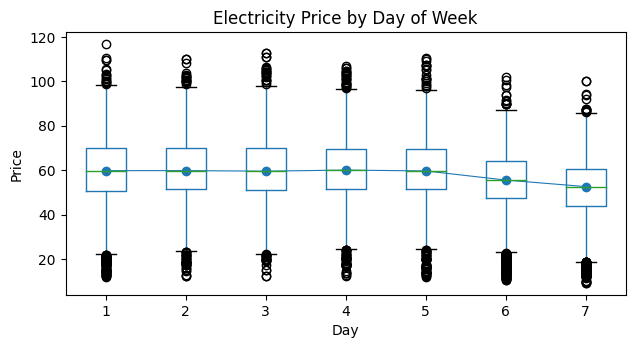

In [37]:
## 2. Weekly Seasonality
fig, ax = plt.subplots(figsize = [7, 3.5])
price_df['day_of_week'] = price_df.index.day_of_week + 1
price_df.boxplot(column='price actual', by = 'day_of_week', ax = ax)
price_df.groupby('day_of_week')['price actual'].median().plot(style='o-', linewidth = 0.8, ax = ax)
ax.set_ylabel('Price')
ax.set_xlabel('Day')
fig.suptitle('')
ax.set_title('Electricity Price by Day of Week')
plt.show()

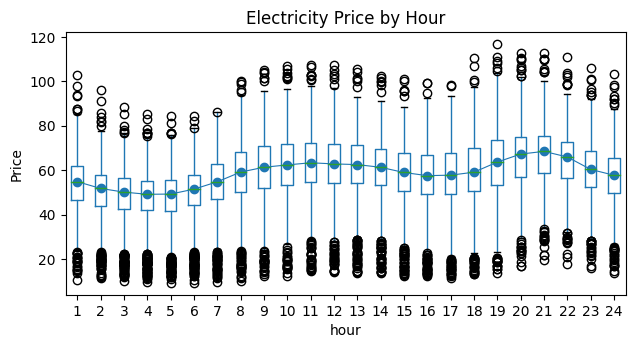

In [38]:
## 3. Daily seasonality
fig, ax = plt.subplots(figsize = [7, 3.5])
price_df['hour'] = price_df.index.hour + 1
price_df.boxplot(column='price actual', by = 'hour', ax = ax)
price_df.groupby('hour')['price actual'].median().plot(style='o-', linewidth = 0.8, ax = ax)
ax.set_ylabel('Price')
ax.set_xlabel('hour')
fig.suptitle('')
ax.set_title('Electricity Price by Hour')
plt.show()

## Autocorrelation and Partial Autocorrelation

Text(0.5, 0, 'Lag')

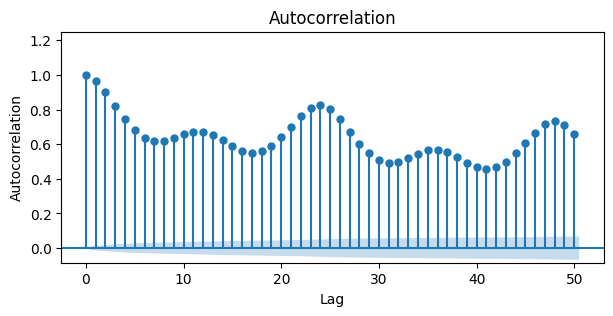

In [39]:
fig, ax = plt.subplots(figsize=[7, 3])
plot_acf(
    x = price_df["price actual"],
    lags = 50,
    ax = ax,
    alpha = 0.05,
    auto_ylims = True
)
ax.set_title('Autocorrelation')
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag')

Text(0.5, 0, 'Lag')

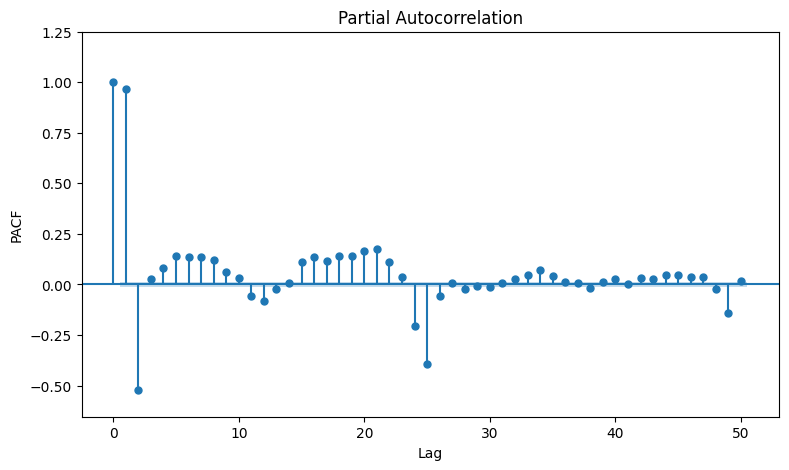

In [40]:
fig, ax = plt.subplots(figsize=[9, 5])
plot_pacf(
    x = price_df["price actual"],
    lags = 50,
    ax = ax,
    alpha = 0.05,
    auto_ylims = True,
    method = 'ywm'
)
ax.set_title('Partial Autocorrelation')
ax.set_ylabel('PACF')
ax.set_xlabel('Lag')

## Test for stationarity

In [41]:
from statsmodels.tsa.stattools import adfuller
X = price_df["price actual"]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items(): print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.147016
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The ADF Statistic (-9.14) is less than the critical value at 1% (-3.43) and thus, we can say that we reject the null hypothesis with a significance level of 1%, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing.

In [42]:
price_df

,price actual,lowess,month,day_of_week,hour
time,,,,,
2015-01-01 00:00:00+01:00,65.41,65.892154,1,4,1
2015-01-01 01:00:00+01:00,64.92,65.886955,1,4,2
2015-01-01 02:00:00+01:00,64.48,65.881756,1,4,3
2015-01-01 03:00:00+01:00,59.32,65.876559,1,4,4
2015-01-01 04:00:00+01:00,56.04,65.871362,1,4,5
...,...,...,...,...,...
2018-12-31 19:00:00+01:00,77.02,65.537709,12,1,20
2018-12-31 20:00:00+01:00,76.16,65.534838,12,1,21
2018-12-31 21:00:00+01:00,74.30,65.531967,12,1,22


In [45]:
# Save csv
price_df = price_df.drop(["lowess", "month", "day_of_week", "hour"], axis = 1)
price_df.to_csv("../data/processed/price_actual_df.csv")